In [50]:
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gmean
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from doe_modules.preferences import kwarg_savefig, outputdir
from doe_modules.ml import plot_pr, plot_roc
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score
from sklearn.linear_model import LogisticRegression

from doe_modules.simulation.esm4_metrics import (
    positive_pathway_coverage, max_positive_edge_density, pathway_positivity, 
    max_synergetic_edge_density, 
    pathway_coverage, edge_coverage,
    max_positive_cascade_length_ratio
)

In [3]:
edges = np.array(list(map(list, product([-1, 0, 1], repeat=10))))

df = pd.read_feather(
    f"{outputdir}/esm_test4.feather"
).assign(
    positive_pathway_coverage=pd.DataFrame({
        "positive_pathway_coverage": map(positive_pathway_coverage, edges),
    })
).assign(
    max_positive_edge_density=pd.DataFrame({
        "max_positive_edge_density": map(lambda x: 1 - max_positive_edge_density(x), edges),
    })
)

df = df.assign(
    arithmetic=df.iloc[:, 4:6].mean(axis=1)
).assign(
    better_with_pb=df.pb > df.cloo
)

In [4]:
df

,cloo,pb,v,,positive_pathway_coverage,max_positive_edge_density,arithmetic,better_with_pb
0,0.000000,0.000000,0,neither,0.0,1.00,0.500,False
1,0.000000,0.000000,0,neither,0.0,1.00,0.500,False
2,0.000000,0.000000,0,neither,0.0,1.00,0.500,False
3,0.000000,0.000000,0,neither,0.0,1.00,0.500,False
4,0.000000,0.000000,0,neither,0.0,1.00,0.500,False
...,...,...,...,...,...,...,...,...
59044,0.750000,0.750000,3,both,1.0,0.25,0.625,False
59045,1.000000,0.750000,1,C+LOO,1.0,0.00,0.500,False
59046,0.333333,-0.333333,0,neither,1.0,0.50,0.750,False
59047,0.750000,0.750000,3,both,1.0,0.40,0.700,False


In [5]:
def cai_performance(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return np.vectorize(lambda t: metric(data.cloo < data.pb, data.cai <= t))(xrange)

def cai_performance_plot(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return (xrange, cai_performance(data, metric, xrange))

def argmax_cai(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    y = cai_performance(data, metric, xrange)
    argmax = np.argmax(y)
    return (xrange[argmax], y[argmax])

In [21]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score, recall_score, precision_score, precision_recall_curve

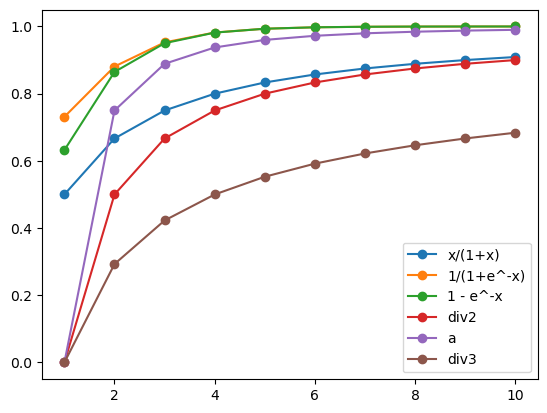

In [8]:
fig, ax = plt.subplots()

nx = np.linspace(1, 10, 10)

ax.plot(nx, np.vectorize(lambda x: x / (1 + x))(nx), label="x/(1+x)", marker="o")
ax.plot(nx, np.vectorize(lambda x: 1 / (1 + np.e ** (-x)))(nx), label="1/(1+e^-x)", marker="o")
ax.plot(nx, np.vectorize(lambda x: 1 - np.e ** (-x))(nx), label="1 - e^-x", marker="o")
ax.plot(nx, np.vectorize(lambda x: 1 - (1 / x))(nx), label="div2", marker="o")
ax.plot(nx, np.vectorize(lambda x: 1 - (1 /  (x ** 2)))(nx), label="a", marker="o")
ax.plot(nx, np.vectorize(lambda x: 1 - (1 /  (x ** .5)))(nx), label="div3", marker="o")

ax.legend()

In [9]:
def div22(arr):
    n = (-1 + np.sqrt(1 + 8 * arr.size)) / 2
    weight = np.array([1 / n, 1 - (1 / n)])
    val = np.array([
        positive_pathway_coverage(arr),
        (1 - max_positive_edge_density(arr)),
    ])
    return (weight * val).sum() / weight.sum()

In [10]:
df = df.assign(
    div22=pd.DataFrame({
        "": map(div22, edges),
    })
)

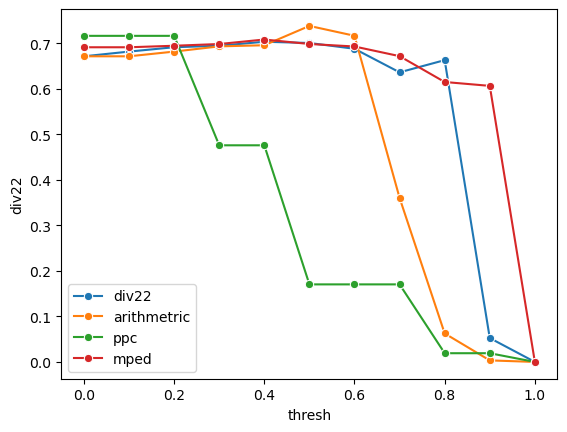

In [13]:
from sklearn.metrics import f1_score

fig, ax = plt.subplots()

thresh = np.linspace(0, 1, 11)
hoge = pd.DataFrame({
    "thresh": thresh,
    "div22": np.vectorize(lambda t: f1_score(df.better_with_pb, df.div22 > t))(thresh),
    "arithmetric": np.vectorize(lambda t: f1_score(df.better_with_pb, df.arithmetic > t))(thresh),
    "ppc": np.vectorize(lambda t: f1_score(df.better_with_pb, df.positive_pathway_coverage > t))(thresh),
    "mped": np.vectorize(lambda t: f1_score(df.better_with_pb, df.max_positive_edge_density > t))(thresh),
})

for key in ["div22", "arithmetric", "ppc", "mped"]:
    sns.lineplot(
        data=hoge, x="thresh", y=key, label=key, marker="o"
    )

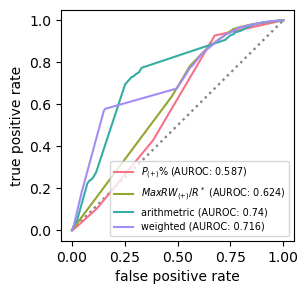

In [52]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [
    df.positive_pathway_coverage, df.max_positive_edge_density, 
    df.arithmetic, 
    df.div22, 
]

names = [
    "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", 
    "arithmetric", 
    "weighted",
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small")
ax.set(xlabel="false positive rate", ylabel="true positive rate")

fig.savefig(f"{outputdir}/test4_roc", **kwarg_savefig)

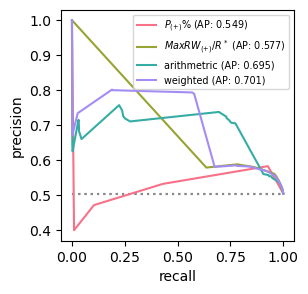

In [53]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [
    df.positive_pathway_coverage, df.max_positive_edge_density, 
    df.arithmetic, 
    df.div22, 
]

names = [
    "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", 
    "arithmetric", 
    "weighted",
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + f" (AP: {average_precision_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    base = df.better_with_pb.value_counts().cumsum()[0] / df.better_with_pb.value_counts().cumsum()[1]
    ax.plot([0, 1], [base, base], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small")
ax.set(xlabel="recall", ylabel="precision")

fig.savefig(f"{outputdir}/test4_pr", **kwarg_savefig)

In [97]:
from sklearn.metrics import precision_recall_curve

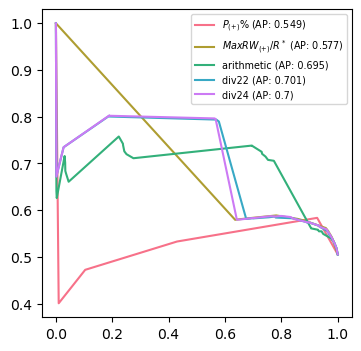

In [98]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    df.positive_pathway_coverage, df.max_positive_edge_density, 
    df.arithmetic, 
    df.div22, 
    df.div24,
]

names = [
    "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", 
    "arithmetic", 
    "div22", 
    "div24",
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + f" (AP: {average_precision_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )

ax.legend(fontsize="x-small")

<AxesSubplot: ylabel='max_positive_edge_density'>

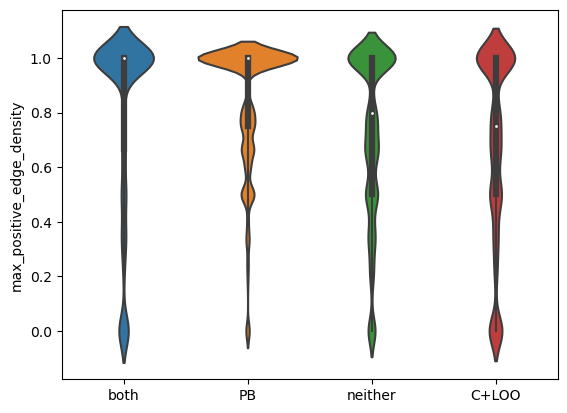

In [151]:
sns.violinplot(data=df, y=df.max_positive_edge_density, x="")

In [154]:
df

,cloo,pb,v,,positive_pathway_coverage,max_positive_edge_density,pathway_positivity,pathway_coverage,edge_sparsity,pai,met1100,met0110,met0101,met1110,met1101,met0111,arithmetic,geometric,better_with_pb,arith0101,max0101,min0101,div0101,e0101,div2,div3
0,1.000000,1.000000,3,both,0.0,1.00,0.0,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.5000,1.0,False,1.000,1.0,1.00,0.50,0.500000,0.50000,0.5000
1,1.000000,1.000000,3,both,0.0,1.00,0.0,1.0,0.166667,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.5000,1.0,False,1.000,1.0,1.00,0.50,0.500000,0.50000,0.5000
2,1.000000,1.000000,3,both,0.0,1.00,0.0,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.5000,1.0,False,1.000,1.0,1.00,0.50,0.500000,0.50000,0.5000
3,1.000000,1.000000,3,both,0.0,1.00,0.0,1.0,0.166667,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.5000,1.0,False,1.000,1.0,1.00,0.50,0.500000,0.50000,0.5000
4,1.000000,1.000000,3,both,0.0,1.00,0.0,1.0,0.333333,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.5000,1.0,False,1.000,1.0,1.00,0.50,0.500000,0.50000,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59044,1.000000,1.000000,3,both,1.0,0.25,1.0,1.0,0.333333,0.571429,0.400000,0.400000,0.400000,0.500000,0.500000,0.500000,0.8125,1.0,False,0.625,1.0,0.25,0.20,0.131745,0.21875,0.3125
59045,1.000000,0.750000,1,C+LOO,1.0,0.00,1.0,1.0,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.7500,1.0,False,0.500,1.0,0.00,0.10,0.008993,0.12500,0.2500
59046,0.333333,-0.333333,0,neither,1.0,0.50,1.0,1.0,0.000000,0.800000,0.666667,0.666667,0.666667,0.750000,0.750000,0.750000,0.8750,1.0,False,0.750,1.0,0.50,0.30,0.254497,0.31250,0.3750
59047,0.750000,0.750000,3,both,1.0,0.40,1.0,1.0,0.166667,0.727273,0.571429,0.571429,0.571429,0.666667,0.666667,0.666667,0.8500,1.0,False,0.700,1.0,0.40,0.26,0.205396,0.27500,0.3500


In [155]:
df = df.assign(
    edge_coverage=pd.DataFrame({
        "": map(edge_coverage, edges),
    })
)

In [103]:
feat_names_short = dict(
    pathway_coverage=r"P%",
    pathway_positivity=r"P$_{(+)}$/P",
    pathway_negativity=r"P$_{(-)}$/P",
    positive_pathway_coverage=r"P$_{(+)}$%",
    negative_pathway_coverage=r"P$_{(-)}$%",
    sparse_pathway_coverage=r"P$_{(0)}$%",
    edge_coverage=r"R%",
    edge_positivity=r"R$_{(+)}$/R",
    edge_negativity=r"R$_{(-)}$/R",
    positive_edge_coverage=r"R$_{(+)}$%",
    negative_edge_coverage=r"R$_{(-)}$%",
    sparse_edge_coverage=r"R$_{(0)}$%",
    edge_effectivity=r"R$^*$/R",
    effective_edge_positivity=r"R$^*_{(+)}$/R$^*$",
    effective_edge_negativity=r"R$^*_{(-)}$/R$^*$",
    max_edge_density=r"MaxRW/R$^*$",
    mean_edge_density=r"RW%",
    max_positive_edge_density=r"MaxRW$_{(+)}$/R$^*$",
    mean_positive_edge_density=r"RW$_{(+)}$%",
    max_synergetic_edge_density=r"MaxRW$_&$/R$^*$",
    mean_synergetic_edge_density=r"RW$_&$%",
    max_factor_density=r"MaxFW/n",
    mean_factor_density=r"FW%",
    max_positive_factor_density=r"MaxFW$_{(+)}$/n",
    mean_positive_factor_density=r"FW$_{(+)}$%",
    max_synergetic_factor_density=r"MaxFW$_&$/n",
    mean_synergetic_factor_density=r"FW$_&$%",
    max_cascade_length_ratio=r"MaxCL/n",
    mean_cascade_length_ratio=r"CL%",
    max_positive_cascade_length_ratio=r"MaxCL$_{(+)}$/n",
    mean_positive_cascade_length_ratio=r"CL$_{(+)}$%",
    max_synergetic_cascade_length_ratio=r"MaxCL$_&$/n",
    mean_synergetic_cascade_length_ratio=r"CL$_&$%",
    # cascade_coverage=r"C%",
    # positive_cascade_coverage=r"C$_+$%",
    # synergetic_cascade_coverage=r"C$_&$%",
)

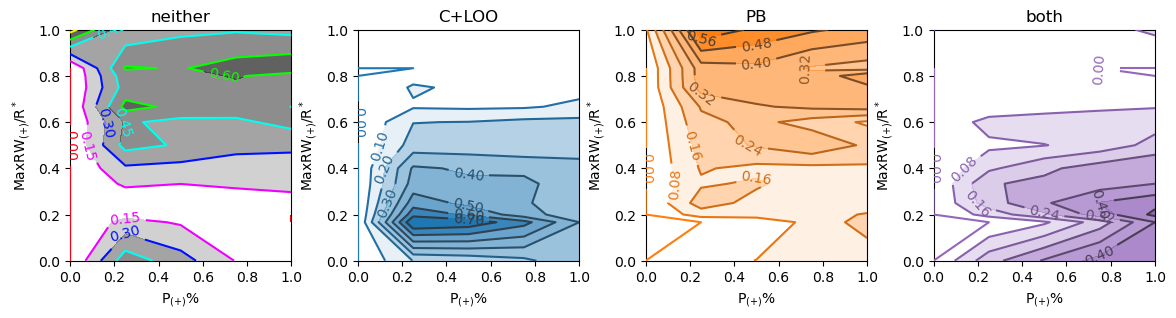

In [104]:
import matplotlib.colors as mcolors

keyx = "positive_pathway_coverage"
keyy = "max_positive_edge_density"

x1d = np.sort(df.loc[:, keyx].unique())
y1d = np.sort(df.loc[:, keyy].unique())
x2d, y2d = np.meshgrid(x1d, y1d)


def query_ratio(sorted_df, key):
    df_vals = sorted_df.value_counts() / sorted_df.size
    return df_vals[key] if key in df_vals.index else 0

df_ratios = pd.DataFrame({
    keyx: x2d.ravel(),
    keyy: y2d.ravel(),
    **{
        k: np.array([
            query_ratio(
                df[(df.loc[:, keyx] == x) & (df.loc[:, keyy] == y)].v,
                k
            ) for x, y in zip(x2d.ravel(), y2d.ravel())
        ]) for k in np.sort(df.v.unique())
    }
    
})

fig, ax = plt.subplots(
    1, 4, figsize=(14, 3), 
    # sharex=True, sharey=True
)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for i, a in enumerate(ax.ravel()):
    
    rgb = mcolors.to_rgb({0: ".2", 1: "C0", 2: "C1", 3: "C4"}[i])
    cmap_contour = mcolors.ListedColormap(
        [(r, g, b, 1) for r, g, b in zip(*[np.linspace(c, 0.2, 10) for c in rgb])]
    )
    
    a.contourf(
        x2d, y2d, df_ratios.loc[:, i].values.reshape(x2d.shape),
        cmap=mcolors.ListedColormap([(*rgb, alpha) for alpha in np.linspace(1.0, 0, 10)[::-1]])
    )
    contour = a.contour(
        x2d, y2d, df_ratios.loc[:, i].values.reshape(x2d.shape),
        cmap="hsv_r" if i == 0 else cmap_contour, 
        zorder=100
    )
    contour.clabel(fmt=f'%.{2}f')
    a.set(
        title={i: v for i, v in enumerate(["neither", "C+LOO", "PB", "both"])}[i],
        xlabel=feat_names_short[keyx], ylabel=feat_names_short[keyy]
    )

# if conf.savefig:
#     fig.savefig(f"{conf.out}/contour_{key_c}_vs_{key_r}{conf.suffix}", **kwarg_savefig)

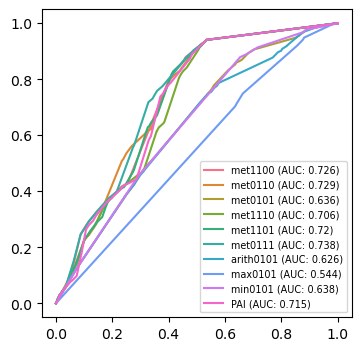

In [100]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    # df.positive_pathway_coverage, df.max_positive_edge_density, df.pathway_positivity,
    # df.pathway_coverage, 
    # df.edge_sparsity,
    # df.arithmetic, df.geometric, 
    df.met1100, df.met0110, df.met0101, df.met1110, df.met1101, df.met0111,
    df.arith0101, df.max0101, df.min0101,
    df.pai
]

names = [
    # "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", "$P_{(+)}/P$", 
    # "$P\%$", 
    # "$1-R\%$",
    # "arithmetic", "geometric", 
    "met1100", "met0110", "met0101", "met1110", "met1101", "met0111",
    "arith0101", "max0101", "min0101",
    "PAI"
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )

ax.legend(fontsize="x-small")

In [58]:
from sklearn.metrics import precision_recall_curve

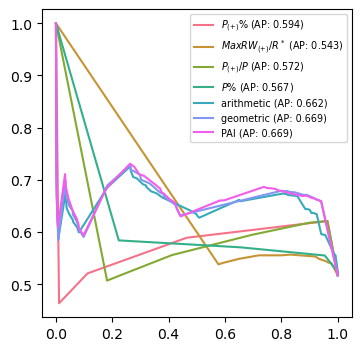

In [59]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    df.positive_pathway_coverage, df.max_positive_edge_density, df.pathway_positivity,
    df.pathway_coverage, 
    # df.edge_sparsity,
    df.arithmetic, df.geometric, 
    df.pai
]

names = [
    "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", "$P_{(+)}/P$", 
    "$P\%$", 
    # "$1-R\%$",
    "arithmetic", "geometric", 
    "PAI"
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + f" (AP: {average_precision_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )

ax.plot(np.linspace(0, 1, 10), np.linspace(1, 1, 10), c=".7", alpha=0)

ax.legend(fontsize="x-small")

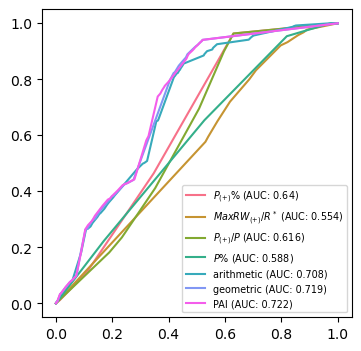

In [57]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    df.positive_pathway_coverage, df.max_positive_edge_density, df.pathway_positivity,
    df.pathway_coverage, 
    # df.edge_sparsity,
    df.arithmetic, df.geometric, 
    df.pai
]

names = [
    "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", "$P_{(+)}/P$", 
    "$P\%$", 
    # "$1-R\%$",
    "arithmetic", "geometric", 
    "PAI"
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )

ax.legend(fontsize="x-small")

In [58]:
from sklearn.metrics import precision_recall_curve

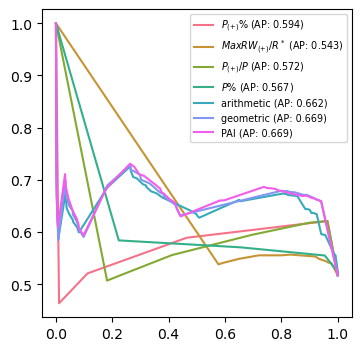

In [59]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    df.positive_pathway_coverage, df.max_positive_edge_density, df.pathway_positivity,
    df.pathway_coverage, 
    # df.edge_sparsity,
    df.arithmetic, df.geometric, 
    df.pai
]

names = [
    "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", "$P_{(+)}/P$", 
    "$P\%$", 
    # "$1-R\%$",
    "arithmetic", "geometric", 
    "PAI"
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + f" (AP: {average_precision_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )

ax.plot(np.linspace(0, 1, 10), np.linspace(1, 1, 10), c=".7", alpha=0)

ax.legend(fontsize="x-small")